# New York Fare Classification

Download New York Fare dataset at Google Classroom

Objectives 
- learn embeddings (done!)
- learn dropout (done! yay!)
- serve as another case study

Embedding
- a very powerful concept
- replaces label-encoding and one-hot encoding
  - label-encoding:  turns category into numbers
  - one-hot encodings: turns category into cols
- In neural network, we don't have to....
  - we instead assign a vector of numbers for each category
  - Let's say I have 1000 samples, one col with two categories (morning, afternoon)
    - SHAPE: (1000, 1)
  - But for neural network, we can first create random vectors representing each category
    - morning:   [1, 5, 0.3, 2, 5]
    - afternoon: [4, 3, 0.2, 1, 0.9]
    - SHAPE: (1000, 2, 5)

## 1. ETL

In [1]:
#import stuffs
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/NYCTaxiFares.csv")

In [3]:
df.head()
#1. convert UTC to New York time....
#2. extract hours, am/pm, day as features
#3. fare_class is our y/target/label
#4. engineer some distance features

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
#let's check class imbalance of data
#the first thing you must do in any dataset
df['fare_class'].value_counts(normalize=True)
#0 means less than 10 dollars
#1 means greater than equal to 10 dollars
#upsampling - SMOTE
#downsampling - I don't remember
#I think there is a library imblearn - take a look
#remember, if you use cross-validation, do it during cross-validation
#basically, no data leakage........

0    0.666667
1    0.333333
Name: fare_class, dtype: float64

## 2. EDA

We are lazy today....so skip...

## 3. Feature Engineering

- create the distance column for us

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{align} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{align}$

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi    = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [7]:
#create a column called hav_dis inside df using this function
df['hav_dis'] = haversine_distance(df, 'pickup_latitude', 
                                       'pickup_longitude',
                                       'dropoff_latitude', 
                                       'dropoff_longitude',)

In [8]:
df['hav_dis'].describe()

count    120000.000000
mean          3.322160
std           3.337004
min           0.010208
25%           1.316428
50%           2.237084
75%           4.034564
max          28.846365
Name: hav_dis, dtype: float64

<AxesSubplot:xlabel='fare_class', ylabel='hav_dis'>

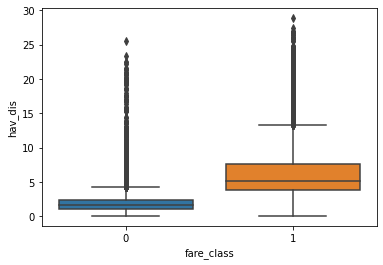

In [9]:
#a little bit
#bivariate analysis between hav_dis and fare_class
import seaborn as sns
sns.boxplot(x = df.fare_class, y = df.hav_dis)

## 4. Feature Extraction

1. convert UTC to New York time....
2. extract hours, am/pm, day as features

In [10]:
df['pickup_datetime'].iloc[0]

'2010-04-19 08:17:56 UTC'

In [11]:
#what is the time difference between UTC and New York....
df['new_york_time'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)

In [12]:
#hour  - df['new_york_time'].dt.hour
#day   - df['new_york_time'].dt.strftime("%a")
#am/pm - np.where(hour < 12, 'am', 'pm')
#np.where(condition, if true, if false)
df['hour'] = df['new_york_time'].dt.hour
df['day']  = df['new_york_time'].dt.strftime("%a")
df['ampm'] = np.where(df['hour'] < 12, 'am', 'pm')

In [13]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hav_dis,new_york_time,hour,day,ampm
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,Mon,am
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,Sat,am
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,Sat,am
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,Sun,pm
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,Fri,pm


In [14]:
df['ampm'].unique()

array(['am', 'pm'], dtype=object)

In [15]:
#help me write a simple assert function
#there should be no more than 24 hours
assert len(df['hour'].unique()) <= 24, "More than 24 hours"
assert df['hour'].min() == 0, "Some negative hours!"
assert df['hour'].max() == 23, "Not a normal time system~"

#there should be no more than 7 days
assert len(df['day'].unique()) == 7, "Something not Mon-Sun"

#there should be only am and pm
assert (df['ampm'].unique() == np.array(['am', 'pm'])).all()

In [16]:
#columns name
cat_cols  = ['hour', 'ampm', 'day']
cont_cols = ['pickup_latitude', 'pickup_longitude', 
             'dropoff_latitude', 'dropoff_longitude',
             'passenger_count', 'hav_dis'] 
y         = ['fare_class']

In [17]:
#there is a dtype called category
#which gonna neatly turns our data into integers....
#basically it's like label encoding, but much more
#why we need to turn it into category first
#because, the embedding is like for 0, 1, 2
for col in cat_cols:
    df[col] = df[col].astype('category')

In [18]:
df['ampm'].cat.categories

Index(['am', 'pm'], dtype='object')

In [19]:
df['ampm'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [20]:
df['ampm'].cat.codes.values

array([0, 0, 0, ..., 1, 0, 1], dtype=int8)

## 6. Cleaning

In [22]:
df.isna().sum() #let me guess, no missing values

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hav_dis              0
new_york_time        0
hour                 0
day                  0
ampm                 0
dtype: int64

## 7. Define X and y

In [23]:
#stack the hours, ampm, and day as one vector

hr   = df['hour'].cat.codes.values #[vectors of hours, e.g., 0, 4, 2]
ampm = df['ampm'].cat.codes.values
day  = df['day'].cat.codes.values

time = np.stack([hr, ampm, day], axis=1)

time[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [24]:
time.shape  #(120000 samples, 3 features)

(120000, 3)

In [25]:
#convert this numpy into tensor
time = torch.tensor(time, dtype=torch.int64)
time[:3]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2]])

In [27]:
#similarly, we want to stack them into a vector of size 6
lat1  = df['pickup_latitude'].values  #.values give you the numpy vector
lat2  = df['dropoff_latitude'].values
long1 = df['pickup_longitude'].values
long2 = df['dropoff_longitude'].values
ps_count = df['passenger_count'].values
hav_dis  = df['hav_dis'].values
#use list comprehension
#[df[col].values for col in cont_cols]

conts = np.stack([lat1, lat2, long1, long2, ps_count, hav_dis], axis=1)

#turn this into tensor...
conts = torch.tensor(conts, dtype=torch.float32)

conts[:4]


tensor([[ 40.7305,  40.7447, -73.9924, -73.9755,   1.0000,   2.1263],
        [ 40.7406,  40.7441, -73.9901, -73.9742,   1.0000,   1.3923],
        [ 40.7511,  40.7662, -73.9941, -73.9601,   2.0000,   3.3268],
        [ 40.7564,  40.7482, -73.9905, -73.9712,   1.0000,   1.8641]])

In [28]:
conts.shape  #(120000, 6)

torch.Size([120000, 6])

In [29]:
#finally, we need the y, to be in tensor
y = torch.tensor(df[y].values).flatten()  #reshape(-1)
y.shape

torch.Size([120000])

## 8. Determine the embedding size

- Before we create the embedding, we need to specify the embedding size....
- Two ways:  
  - randomly pick a size
    - min(50, unique/2)
  - specify a size

In [30]:
#get the size of all my categorical cols
cat_size = [len(df[col].cat.categories) for col in cat_cols]
cat_size
#[24, 2, 7]  #[24, 7, 2]

[24, 2, 7]

In [31]:
emb_size = [(size, min(50, size//2)) for size in cat_size]
emb_size

[(24, 12), (2, 1), (7, 3)]

## 9. Try to illustrate how Embedding layer works

In [36]:
sample = time[:1]
sample


tensor([[4, 0, 1]])

In [37]:
twosamples = time[:2]
twosamples

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [38]:
#expected output after embedding of sample
#[  [[12 numbers]], [[1 number]], [[3 numbers]]]

#expected output after embedding of sample
#[  [[12 numbers], [12 numbers]],   [[1 number], [1 number]], 
#   [[3 numbers], [3 numbers]]    ]

In [39]:
#emb_size: [(24, 12), (2, 1), (7, 3)]
#but pyTorch does not have a list of nn.Embedding
#if you want pyTorch to have a list of layers, use nn.ModuleList
embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])

In [40]:
embed_layer

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 3)
)

In [41]:
#empty embedding
sample_embedding = []

for i, e in enumerate(embed_layer):
    sample_embedding.append(e(twosamples[:, i])) #apply embedding layer to column i
                                                 #apply embedding layer 0 to column 0

In [42]:
sample_embedding

[tensor([[ 0.7660, -0.9331, -1.6040,  0.8839, -0.1780,  0.9149,  1.4179, -0.7277,
          -1.1239,  1.0298,  0.0264, -0.6373],
         [-0.7624, -1.5945,  0.3104, -0.4983,  1.3355, -0.1131, -0.0539, -0.8171,
           0.0861, -0.7153, -0.8865,  0.6776]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.4246],
         [-0.4246]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.5708,  0.0035,  0.8065],
         [-0.2147, -0.8733, -0.8268]], grad_fn=<EmbeddingBackward0>)]

In [43]:
# in coding, we want to concat all these embeddings, into one vector
final_embedding = torch.cat(sample_embedding, axis=1)

final_embedding

tensor([[ 0.7660, -0.9331, -1.6040,  0.8839, -0.1780,  0.9149,  1.4179, -0.7277,
         -1.1239,  1.0298,  0.0264, -0.6373, -0.4246,  1.5708,  0.0035,  0.8065],
        [-0.7624, -1.5945,  0.3104, -0.4983,  1.3355, -0.1131, -0.0539, -0.8171,
          0.0861, -0.7153, -0.8865,  0.6776, -0.4246, -0.2147, -0.8733, -0.8268]],
       grad_fn=<CatBackward0>)

In [44]:
final_embedding.shape

torch.Size([2, 16])

In [45]:
#gonna teach you very briefly about nn.Dropout
#define a dropout layer
dl = nn.Dropout(0.5)

In [46]:
final_embedding = dl(final_embedding)
final_embedding

tensor([[ 0.0000, -1.8662, -0.0000,  0.0000, -0.3561,  1.8298,  2.8358, -1.4553,
         -0.0000,  2.0596,  0.0528, -1.2747, -0.0000,  0.0000,  0.0000,  1.6130],
        [-1.5248, -3.1889,  0.0000, -0.9966,  2.6711, -0.0000, -0.1078, -1.6342,
          0.1722, -0.0000, -1.7729,  0.0000, -0.0000, -0.0000, -0.0000, -1.6535]],
       grad_fn=<MulBackward0>)

In [47]:
final_embedding.shape

torch.Size([2, 16])

## 10. Define the model

In [48]:
sample_cont = conts[:2]
sample_cont

tensor([[ 40.7305,  40.7447, -73.9924, -73.9755,   1.0000,   2.1263],
        [ 40.7406,  40.7441, -73.9901, -73.9742,   1.0000,   1.3923]])

In [49]:
#format: nn.BatchNorm1d(features)
batch_norm1d = nn.BatchNorm1d(6)

In [50]:
output = batch_norm1d(sample_cont)
output

tensor([[-0.8464,  0.0995, -0.3372, -0.1966,  0.0000,  1.0000],
        [ 0.8456, -0.0997,  0.3414,  0.1961,  0.0000, -1.0000]],
       grad_fn=<NativeBatchNormBackward0>)

In [51]:
conts.shape

torch.Size([120000, 6])

In [52]:
#cat_embedding (120000, 16)
#cont          (120000, 6)

In [53]:
class someNN(nn.Module):
    
    def __init__(self, emb_size, cont_size, out_size, layer_size = [200, 100], p=0.5):
        super().__init__()
        self.embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])
        self.dropout     = nn.Dropout(p)
        self.batchnorm1d = nn.BatchNorm1d(cont_size)
        
        #calculate input_size
        cat_size = sum(emb_s for _, emb_s in emb_size)
        input_size = cat_size + cont_size
        
        #linear(input_size, 200) -> relu -> batchnorm -> dropout
        #linear(200, 100) -> relu -> batchnorm -> dropout
        #linear(100, out_size)
        layerlist = []
        for i in layer_size:
            layerlist.append(nn.Linear(input_size, i))  #(input_size, 200)
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            input_size = i
        layerlist.append(nn.Linear(layer_size[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
            
    def forward(self, x_cat, x_cont):
        #x_cat:  (120000, 3)
        #x_cont: (120000, 6)
        embeddings = []
        for i, e in enumerate(self.embed_layer):
            embeddings.append(e(x_cat[:, i]))
        x = torch.cat(embeddings, 1)  
        #x: (120000, 16)
        x = self.dropout(x)
        
        x_cont = self.batchnorm1d(x_cont)  
        #x_cont: (120000, 6)
        
        x = torch.cat([x, x_cont], 1)
        #x: (120000, 24)
        
        x = self.layers(x)
        
        return x

In [54]:
model = someNN(emb_size, conts.shape[1], len(y.unique()))

### Debugging

In [55]:
#let's test
#random dataset
sample_size = 3
cat_size    = 3
cont_size   = 6

p = 0.5
x_cat_hour  = torch.randint(0, 24,(sample_size, 1))
x_cat_ampm  = torch.randint(0, 2, (sample_size, 1))
x_cat_day   = torch.randint(0, 7, (sample_size, 1))
x_cat_example      = torch.cat([x_cat_hour, x_cat_ampm, x_cat_day], 1)
x_cont_example     = torch.randn(sample_size, cont_size)

In [56]:
x_cat_example

tensor([[21,  0,  4],
        [ 5,  1,  1],
        [18,  1,  0]])

In [57]:
x_cont_example

tensor([[ 0.3645, -0.2743,  0.3079,  0.0089, -0.6804,  0.5761],
        [ 1.9157, -0.5505, -0.2487, -0.0490,  0.1130, -0.3351],
        [-1.5442, -0.7426, -1.5445,  0.3638, -0.8550, -0.1221]])

In [58]:
output = model(x_cat_example, x_cont_example)

In [59]:
output

tensor([[-0.8154, -0.4577],
        [-0.3672,  1.1497],
        [ 0.5056, -1.5812]], grad_fn=<AddmmBackward0>)

## 11. Training!!!

In [60]:
#define loss function 
J_fn = nn.CrossEntropyLoss()

In [61]:
#define optimizer (you can try use Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
#Adam have dynamic learning schedules....
#but it is NOT proven that Adam is better than SGD....

In [62]:
y.shape

torch.Size([120000])

In [63]:
#why you not use 120000, too lazy to wait
#why you don't use dataloader, because our data is small, only 9 features....

#train test split
train_size = 60000
test_size  = 12000

#use your numpy indexing technique
cat_train = time[:train_size]
cat_test  = time[train_size:test_size+train_size]
con_train = conts[:train_size]
con_test  = conts[train_size:test_size+train_size]
y_train   = y[:train_size]
y_test    = y[train_size:test_size+train_size]

In [64]:
epochs = 100

losses = []

for i in range(epochs):
    yhat = model(cat_train, con_train)
    loss = J_fn(yhat, y_train)
    losses.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 25 == 1:
        print(f"Epoch: {i}; Loss: {loss:.2f}")

Epoch: 1; Loss: 0.57
Epoch: 26; Loss: 0.29
Epoch: 51; Loss: 0.27
Epoch: 76; Loss: 0.26


In [65]:
train_loss = [loss.item() for loss in losses]
# train_loss

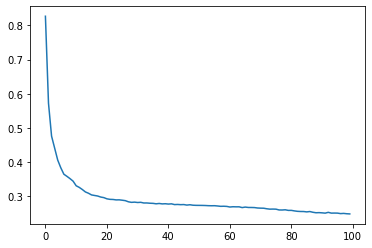

In [66]:
plt.plot(range(epochs), train_loss)

# 12. Testing/Inference

In [67]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    yhat = model(cat_test, con_test)
    loss = J_fn(yhat, y_test)
    predicted = torch.max(yhat, 1)[1]
    acc  = accuracy_score(predicted, y_test)
    
print(acc)

0.9073333333333333
